# Rodando os modelos com Cross Validation

In [1]:
# Bibliotecas de manipualção e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Classes dos modelo
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from imblearn.under_sampling import EditedNearestNeighbours

# Funções de avaliação dos modelos
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ROCAUC


In [2]:
df_hepatite = pd.read_csv('HCV-Egy-Data.csv')

In [3]:
# dataset sem outliers
df_hepatite = pd.read_csv('HCV-Egy-Data-no-outlier.csv')

A remoção de outliers mostrou-se eficiente na performace do modelo aumentando em serca de 1% a acurácia.

In [4]:
df_hepatite.head()

,Unnamed: 0,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,FGba,Jaundice,...,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,BhG,Baselinehistological staging
0,1,46,1,29,1,2,2,1,2,2,...,57,123,44,40620,538635,637056,336804,31085,4,2
1,3,49,2,33,1,2,1,2,1,2,...,48,77,33,1041941,449939,585688,744463,582301,10,3
2,5,58,2,22,2,2,2,1,2,2,...,73,114,29,1157452,1086852,5,5,5,4,4
3,6,42,2,26,1,1,2,2,2,2,...,84,80,28,325694,1034008,275095,214566,635157,12,4
4,7,48,2,30,1,1,2,2,1,1,...,96,53,39,641129,72050,787295,370605,506296,12,3


### Seperação da váriável target do dataset

In [5]:
X = df_hepatite.drop(['BhG', 'Baselinehistological staging'], axis=1)
y = df_hepatite['Baselinehistological staging']

### Normalização dos dados

Com a normalização dos dados o modelo melhorou de predição almentou em um valor de 6% na sua acurácia.

In [6]:
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X)

'''
###### Análise do PCA ################
# O PCA será aplicado para cada 1-Fold
# Aqui será apenas feito uma análise prévia para saber se o PCA está contendo informação nos componentes principais
# Desse modo, analisamos a Razão da Variância e a Variância Acumulativa
# Taxa da Variância Explicada
pca = PCA(n_components = 0.95)
X_PCA = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print('\n')
# Variância acumulativa
print(pca.explained_variance_ratio_.sum())
'''

"\n###### Análise do PCA ################\n# O PCA será aplicado para cada 1-Fold\n# Aqui será apenas feito uma análise prévia para saber se o PCA está contendo informação nos componentes principais\n# Desse modo, analisamos a Razão da Variância e a Variância Acumulativa\n# Taxa da Variância Explicada\npca = PCA(n_components = 0.95)\nX_PCA = pca.fit_transform(X)\nprint(pca.explained_variance_ratio_)\nprint('\n')\n# Variância acumulativa\nprint(pca.explained_variance_ratio_.sum())\n"

In [7]:
#função que retorna um dicionário com os valores dos resultados
def model_results(model, X_train, y_train, X_test, y_test,results_dict_aux):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #medindo e armazenando acurácia, f1-score e auc-score no dicionário
    accuracy = model.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    AUC = roc_auc_score(y_test, model.predict_proba(X_test), average='weighted', multi_class='ovo')
    CM = confusion_matrix(y_test, y_pred)

    results_dict_aux['accuracy'].append(accuracy)
    results_dict_aux['f1'].append(f1)
    results_dict_aux['auc'].append(AUC)
    results_dict_aux['cm'].append(CM)
    '''print(f"f1: {f1}\n")
    print(f"Accuracy: {accuracy}\n")
    print(f"CM: \n{CM} \n")'''
    print(f"AUC: %.6f" %(AUC))
    
    print("-----------------------CURVA ROC---------------------")
    visualizer = ROCAUC(model, encoder={1:"Class 1", 2:"Class 2", 3:"Class 3", 4:"Class 4"})

    visualizer.fit(X_train, y_train)        
    visualizer.score(X_test, y_test)        
    visualizer.show()                       
    #print("-----------------------------------------------------\n")
    return results_dict_aux

## Grid Search

Para cada modelo é implementada uma função do grid search. Para ser aplicada em cada um dos 10 conjuntos de treino do 10-fold.

**KNN**

In [8]:
def kNN_grid_search(X_train, y_train):
    #lista com números impares para o número de vizinhos do knn
    k_range = [impar for impar in range(1,32) if (impar%2)!=0]
    #listas com formas de considerar a ditância do vizinho
    weights = ['uniform', 'distance']
    #lista com formas de calcular as distâncias
    dist = ['euclidian','manhattan','chebyshev']
    #dicionário com parêmetros para o gridsearch
    param_grid = {
        'n_neighbors': k_range,
        'weights': weights,
        'metric': dist
    }
    # defining parameter range
    grid = GridSearchCV(knn(), param_grid, cv=3, scoring='accuracy')
    # fitting the model for grid search
    grid.fit(X_train, y_train)

    #utilizando melhores parâmetros calculados pelo gridsearch
    k = grid.best_params_['n_neighbors']
    w = grid.best_params_['weights']
    m = grid.best_params_['metric']

    print("KNN")
    print(f"Melhores parâmetros - k:{k}, w:{w}, m:{m}")
    print(f"Accuracy: %.6f" %(grid.best_score_))
    print("------------------------------------------------")

    return (k,w,m)

**Decision Tree**

In [9]:
def dt_grid_search(X_train, y_train):
    #
    max_depth_range = [x for x in range(1,32)]
    #listas com formas de medir a qualidade do 'split'
    criterion_list = ['gini', 'entropy']
    #dicionário com parêmetros para o gridsearch
    param_grid = {
        'max_depth': max_depth_range,
        'criterion': criterion_list,
    }
    # defining parameter range
    grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=3, scoring='accuracy')
    # fitting the model for grid search
    grid.fit(X_train, y_train)

    #utilizando melhores parâmetros calculados pelo gridsearch
    md = grid.best_params_['max_depth']
    c = grid.best_params_['criterion']

    print("DT")
    print(f"Melhores parâmetros - md:{md}, c:{c}")
    print(f"Accuracy: %.6f" %(grid.best_score_))
    print("------------------------------------------------")


    return (md,c)

**MLP**

In [10]:
def mlp_grid_search(X_train, y_train):
    # lista com o número de camadas
    hidden_layer_sizes_list = [(100,), (50, 15, 5), (100, 25, 10)]
    # listas das taxas de aprendizado inicial
    learning_rate_init_list = [0.05, 0.0001]
    # lista de estratégias
    solver_list = ['sgd', 'adam']
    # lista das funções de ativações
    activation_list = ['tanh', 'relu']
    # lista da forma da taxa de aprendizado
    learning_rate_lsit = ['constant', 'adaptive']
    # dicionário com parêmetros para o gridsearch
    param_grid = {
        'hidden_layer_sizes': hidden_layer_sizes_list,
        'activation': activation_list,
        'solver': solver_list,
        'learning_rate': learning_rate_lsit,
        'learning_rate_init': learning_rate_init_list,
    }
    # defining parameter range
    grid = GridSearchCV(MLPClassifier(), param_grid, cv=3, scoring='accuracy')
    # fitting the model for grid search
    grid.fit(X_train, y_train)

    # utilizando melhores parâmetros calculados pelo gridsearch
    hls = grid.best_params_['hidden_layer_sizes']
    a = grid.best_params_['activation']
    s = grid.best_params_['solver']
    lr = grid.best_params_['learning_rate']
    lri = grid.best_params_['learning_rate_init']

    print("MLP")
    print(f"Melhores parâmetros - hls:{hls}, a:{a}, s:{s}, lr:{lr}, lri:{lri}")
    print(f"Accuracy: %.6f" %(grid.best_score_))
    print("------------------------------------------------")

    return (hls, a, s, lr, lri)

**SVM**

In [11]:
def svm_grid_search(X_train, y_train):
    #
    C_list = [0.1, 1, 10, 100]
    kernel_list = ['rbf','sigmoid'] #['linear', 'poly', 'rbf', 'sigmoid']
    gamma_list = [1, 0.1, 0.01, 0.001]
    #dicionário com parêmetros para o gridsearch
    param_grid = {
        'C': C_list,
        'kernel': kernel_list,
        'gamma': gamma_list
    }
    # defining parameter range
    grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy')
    # fitting the model for grid search
    grid.fit(X_train, y_train)

    #utilizando melhores parâmetros calculados pelo gridsearch
    c = grid.best_params_['C']
    k = grid.best_params_['kernel']
    g = grid.best_params_['gamma']

    print("SVM")
    print(f"Melhores parâmetros - C:{c}, k:{k}\n, g:{g}")
    print(f"Accuracy: %.6f" %(grid.best_score_))
    print("------------------------------------------------")

    return (c,k,g)

## 10-Fold

Com esse método são criados 10 datasets de treino e 10 datasets de test com uma divisão de 90% para treino e 10% para teste em cada divisão.

O conjunto de treino sera divido mais uma vez em treino e validação (isso é feito dendo da função `GridSearchCV` para que então seja aplicado o GridSearch e assim obtenha-se os melhores parâmetros. Por fim, tendo os melhores parâmetros, utiliza-se o conjunto de teste para que se possa avaliar os resultados.

Esses resultados são obtidos de cada fold e então se tira a média deles para obter-se a avaliação final de cada modelo.

In [12]:
#função que roda os modelos em cada uma das divisões do 10-fold
#e imprime a média e o desvio padrão dos resultados

def evaluate_model_with_kfold(kf):
    results_dict_models = {}
    # listas e dicionarios para salvar as métricas dos resultados de todas as interacoes
    
    results_dict_KNN = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }
    results_dict_DT = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }
    results_dict_MLP = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }
    results_dict_SVM = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }
    results_dict_GNB = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }

    
    for train, test in kf.split(X, y):
        X_train, y_train, X_test, y_test = X.iloc[train], y.iloc[train], X.iloc[test], y.iloc[test]  
        
        #########################################################################
        # PCA - Principal Component Analysis
        # 
        pca = PCA(n_components = 0.95)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        #########################################################################

        #kNN
        k,w,m = kNN_grid_search(X_train_pca, y_train)
        model = knn(n_neighbors=k, weights=w, metric=m)
        results_dict_KNN = model_results(model, X_train_pca, y_train, X_test_pca, y_test, results_dict_KNN)

        #DT
        md,c = dt_grid_search(X_train_pca, y_train)
        model = DecisionTreeClassifier(max_depth=md, criterion=c, random_state=199)
        results_dict_DT = model_results(model, X_train_pca, y_train, X_test_pca, y_test, results_dict_DT)

        #MLP 
        hls, a, s, lr, lri = mlp_grid_search(X_train_pca,y_train)
        model = MLPClassifier(
            hidden_layer_sizes=hls, 
            activation=a, 
            solver=s, 
            learning_rate=lr, 
            learning_rate_init=lri, 
            max_iter=2000, 
            tol=0.000001,
            random_state=199
        )
        results_dict_MLP = model_results(model, X_train_pca, y_train, X_test_pca, y_test, results_dict_MLP)
         
        #GNB 
        model = GaussianNB()
        results_dict_models['GNB'] = model_results(model, X_train_pca, y_train, X_test_pca, y_test, results_dict_GNB)

        #SVM
        c, k, g = svm_grid_search(X_train_pca, y_train)
        model = SVC(C=c, kernel=k, gamma=g, probability=True, random_state=199)
        results_dict_SVM = model_results(model, X_train_pca, y_train, X_test_pca, y_test, results_dict_SVM)

    results_dict_models['KNN'] = results_dict_KNN
    results_dict_models['DT'] = results_dict_DT
    results_dict_models['MLP'] = results_dict_MLP
    results_dict_models['GNB'] = results_dict_GNB
    results_dict_models['SVM'] = results_dict_SVM
    
    # a cada interação calcula a média e o desvio padrão da 
    # acurácia, f1-score, auc-scor e matriz de confusão de cada modelo
    for model_key in results_dict_models.keys():
        accuracies = np.array(results_dict_models[model_key]['accuracy'])
        f1 = np.array(results_dict_models[model_key]['f1'])
        auc = np.array(results_dict_models[model_key]['auc'])
        conf_matrix = np.array(results_dict_models[model_key]['cm'])

        print(f"\t{model_key}")
        print("Acurácia média (desvio): %.6f +- (%.6f)" %(accuracies.mean(), accuracies.std()))
        print("F1-score média (desvio): %.6f +- (%.6f)" %(f1.mean(), f1.std()))
        print("AUC média (desvio): %.6f +- (%.6f)\n" %(auc.mean(), auc.std()))
        print(f"Matriz de Confusão:  \n{sum(conf_matrix)*0.1}")
        # print(f"Matriz de Confusão:  \n{sum(conf_matrix)*0.1}\n")
    print("------------------------------------------------")

In [13]:
import warnings

KNN
Melhores parâmetros - k:5, w:uniform, m:manhattan
Accuracy: 0.272947
------------------------------------------------
AUC: 0.519929
-----------------------CURVA ROC---------------------


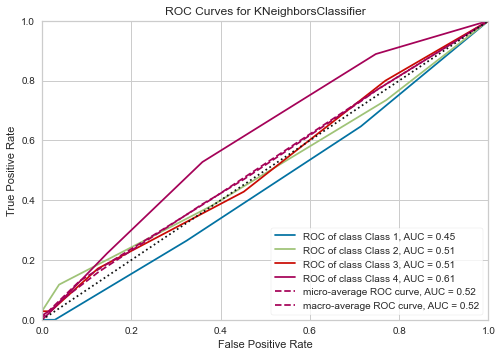

DT
Melhores parâmetros - md:6, c:entropy
Accuracy: 0.262480
------------------------------------------------
AUC: 0.510107
-----------------------CURVA ROC---------------------


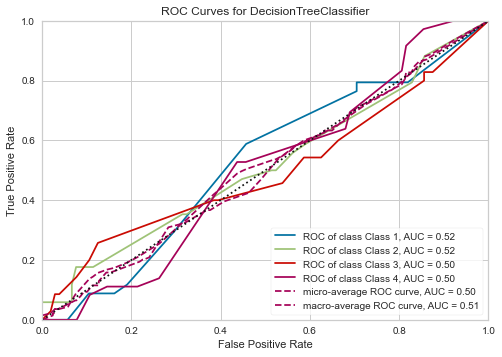

MLP
Melhores parâmetros - hls:(50, 15, 5), a:tanh, s:sgd, lr:adaptive, lri:0.0001
Accuracy: 0.275362
------------------------------------------------
AUC: 0.520880
-----------------------CURVA ROC---------------------


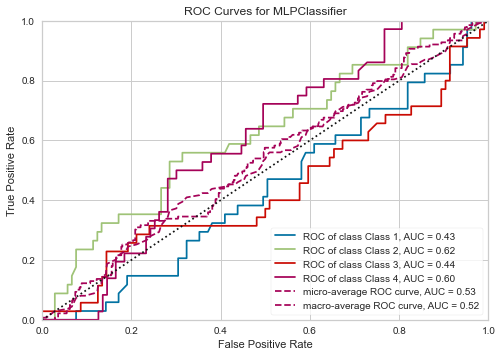

AUC: 0.505173
-----------------------CURVA ROC---------------------


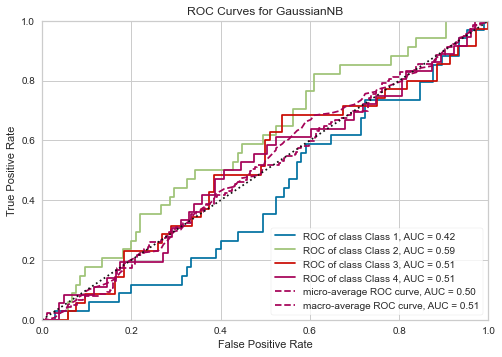

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.260870
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


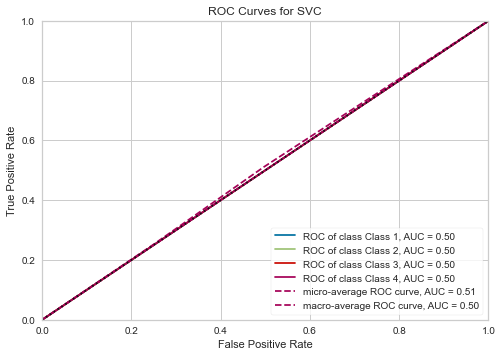

KNN
Melhores parâmetros - k:17, w:uniform, m:chebyshev
Accuracy: 0.280783
------------------------------------------------
AUC: 0.493864
-----------------------CURVA ROC---------------------


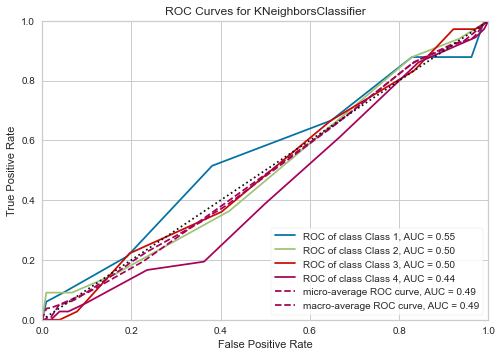

DT
Melhores parâmetros - md:6, c:gini
Accuracy: 0.275147
------------------------------------------------
AUC: 0.496484
-----------------------CURVA ROC---------------------


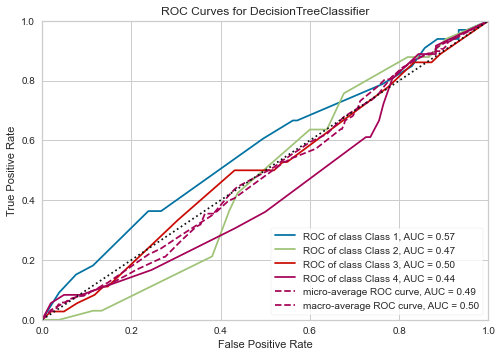

MLP
Melhores parâmetros - hls:(100,), a:tanh, s:adam, lr:adaptive, lri:0.0001
Accuracy: 0.267082
------------------------------------------------
AUC: 0.491647
-----------------------CURVA ROC---------------------


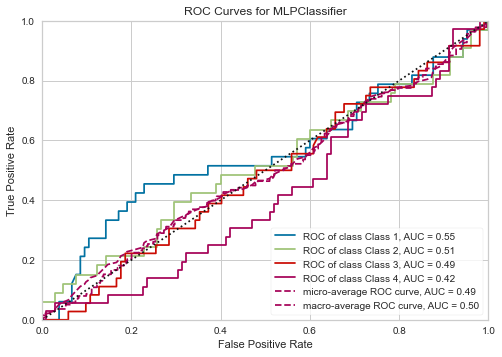

AUC: 0.509860
-----------------------CURVA ROC---------------------


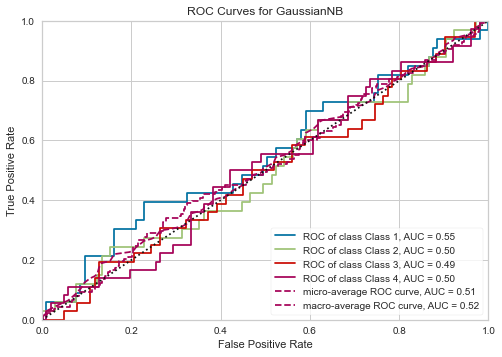

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.260660
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


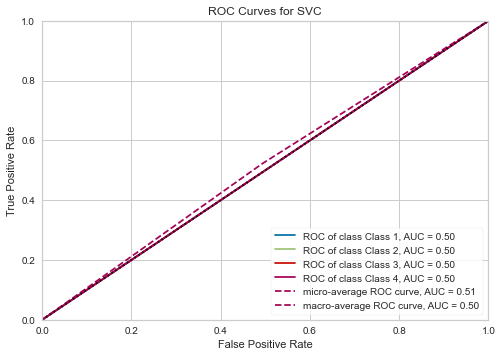

KNN
Melhores parâmetros - k:5, w:uniform, m:manhattan
Accuracy: 0.263885
------------------------------------------------
AUC: 0.550353
-----------------------CURVA ROC---------------------


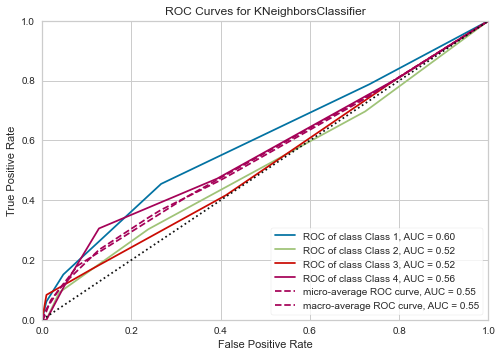

DT
Melhores parâmetros - md:5, c:gini
Accuracy: 0.260645
------------------------------------------------
AUC: 0.547484
-----------------------CURVA ROC---------------------


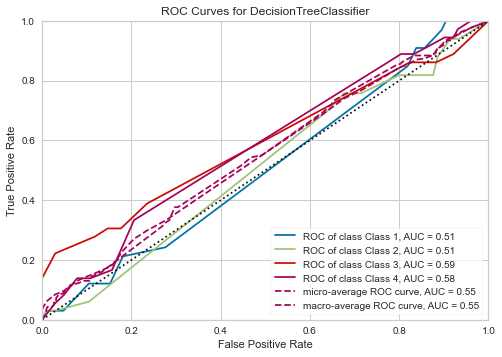

MLP
Melhores parâmetros - hls:(100,), a:tanh, s:adam, lr:adaptive, lri:0.0001
Accuracy: 0.265456
------------------------------------------------
AUC: 0.483260
-----------------------CURVA ROC---------------------


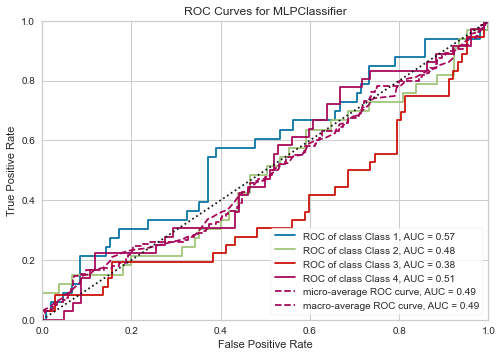

AUC: 0.502867
-----------------------CURVA ROC---------------------


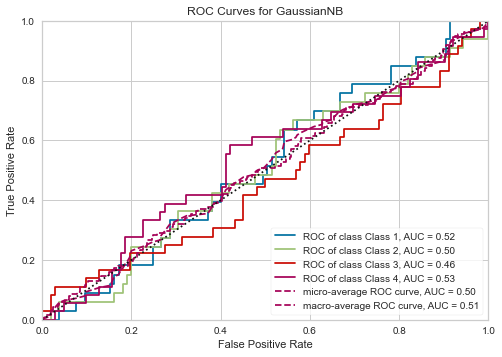

SVM
Melhores parâmetros - C:0.1, k:sigmoid
, g:1
Accuracy: 0.261448
------------------------------------------------
AUC: 0.488097
-----------------------CURVA ROC---------------------


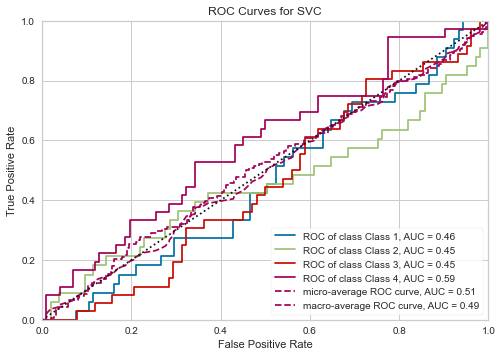

KNN
Melhores parâmetros - k:7, w:distance, m:manhattan
Accuracy: 0.278350
------------------------------------------------
AUC: 0.496631
-----------------------CURVA ROC---------------------


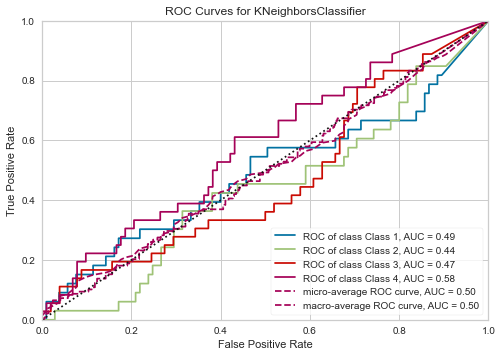

DT
Melhores parâmetros - md:3, c:gini
Accuracy: 0.261465
------------------------------------------------
AUC: 0.500030
-----------------------CURVA ROC---------------------


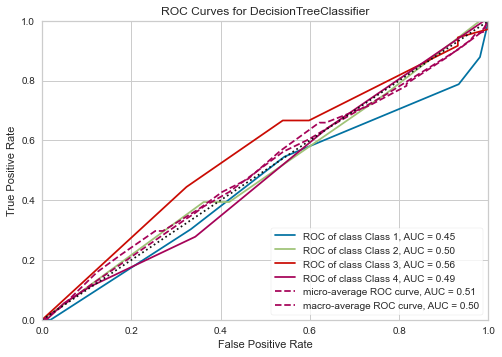

MLP
Melhores parâmetros - hls:(50, 15, 5), a:tanh, s:adam, lr:adaptive, lri:0.05
Accuracy: 0.277555
------------------------------------------------
AUC: 0.487136
-----------------------CURVA ROC---------------------


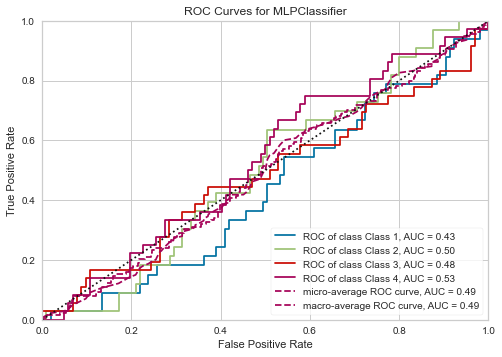

AUC: 0.532551
-----------------------CURVA ROC---------------------


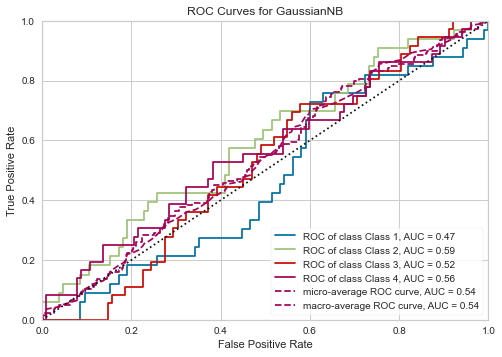

SVM
Melhores parâmetros - C:0.1, k:sigmoid
, g:1
Accuracy: 0.263052
------------------------------------------------
AUC: 0.517701
-----------------------CURVA ROC---------------------


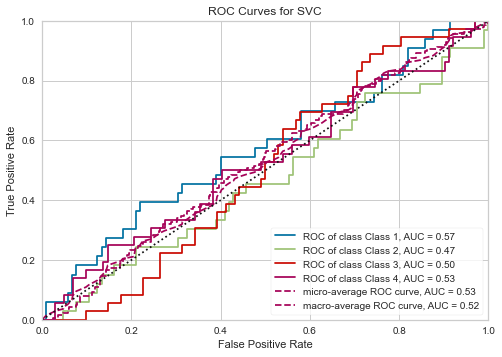

KNN
Melhores parâmetros - k:5, w:uniform, m:manhattan
Accuracy: 0.282378
------------------------------------------------
AUC: 0.460104
-----------------------CURVA ROC---------------------


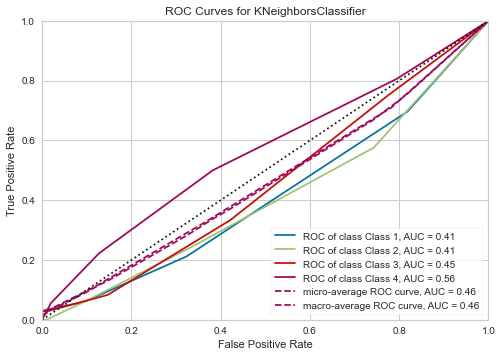

DT
Melhores parâmetros - md:5, c:entropy
Accuracy: 0.267092
------------------------------------------------
AUC: 0.492206
-----------------------CURVA ROC---------------------


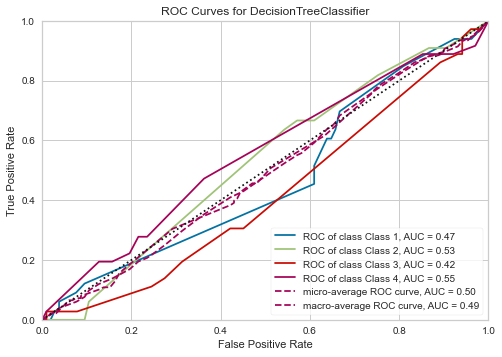

MLP
Melhores parâmetros - hls:(100, 25, 10), a:tanh, s:sgd, lr:adaptive, lri:0.0001
Accuracy: 0.281578
------------------------------------------------
AUC: 0.482573
-----------------------CURVA ROC---------------------


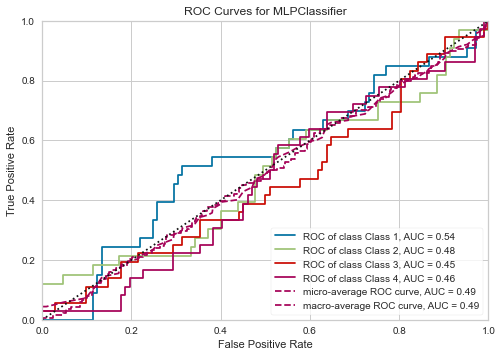

AUC: 0.430598
-----------------------CURVA ROC---------------------


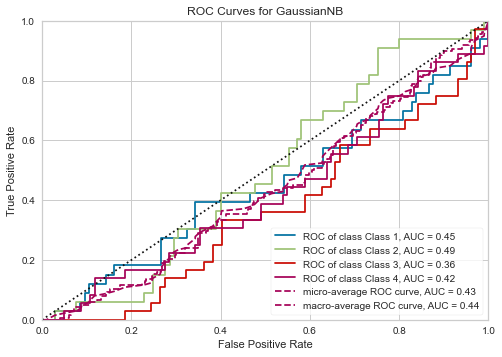

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.260660
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


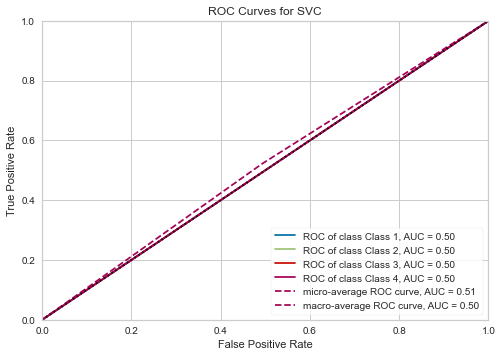

KNN
Melhores parâmetros - k:29, w:uniform, m:manhattan
Accuracy: 0.283992
------------------------------------------------
AUC: 0.502537
-----------------------CURVA ROC---------------------


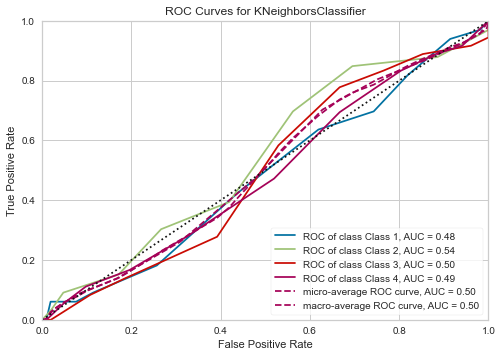

DT
Melhores parâmetros - md:6, c:gini
Accuracy: 0.267113
------------------------------------------------
AUC: 0.483054
-----------------------CURVA ROC---------------------


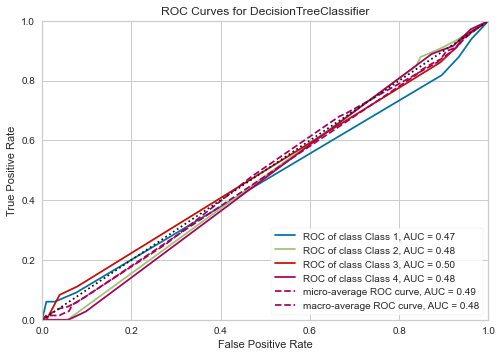

MLP
Melhores parâmetros - hls:(100,), a:tanh, s:sgd, lr:adaptive, lri:0.05
Accuracy: 0.275933
------------------------------------------------
AUC: 0.501159
-----------------------CURVA ROC---------------------


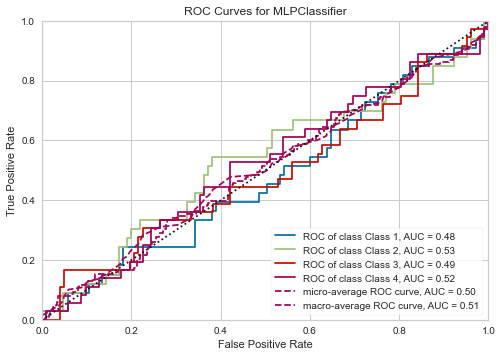

AUC: 0.500384
-----------------------CURVA ROC---------------------


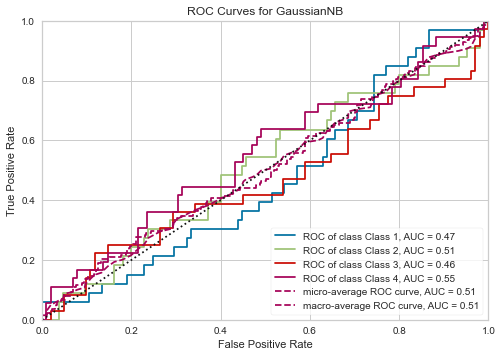

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.260660
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


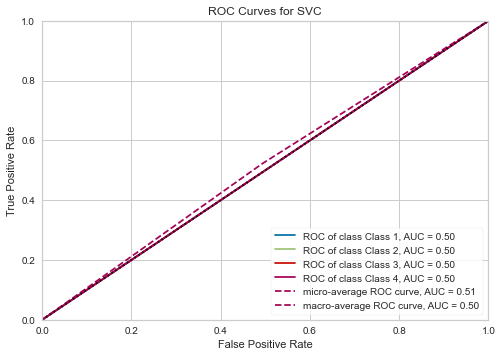

KNN
Melhores parâmetros - k:5, w:uniform, m:manhattan
Accuracy: 0.286415
------------------------------------------------
AUC: 0.479590
-----------------------CURVA ROC---------------------


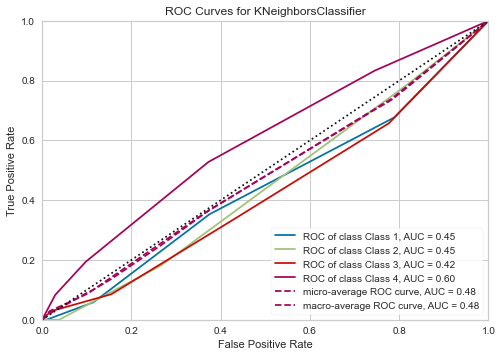

DT
Melhores parâmetros - md:8, c:gini
Accuracy: 0.277547
------------------------------------------------
AUC: 0.496736
-----------------------CURVA ROC---------------------


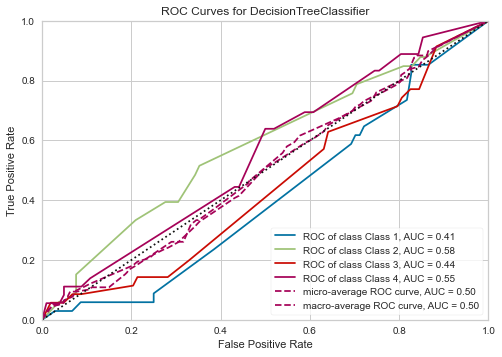

MLP
Melhores parâmetros - hls:(100,), a:tanh, s:adam, lr:constant, lri:0.0001
Accuracy: 0.279169
------------------------------------------------
AUC: 0.507431
-----------------------CURVA ROC---------------------


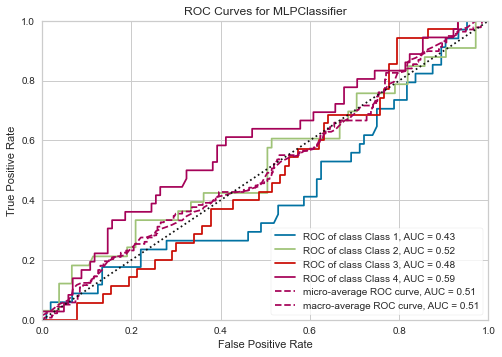

AUC: 0.487720
-----------------------CURVA ROC---------------------


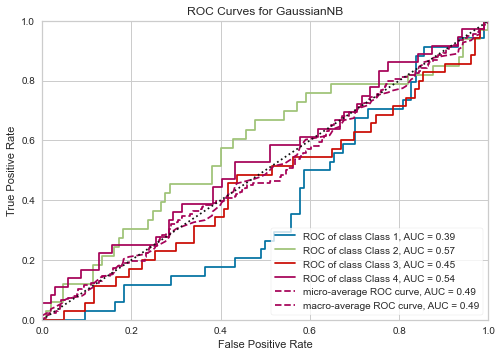

SVM
Melhores parâmetros - C:1, k:sigmoid
, g:1
Accuracy: 0.261448
------------------------------------------------
AUC: 0.435940
-----------------------CURVA ROC---------------------


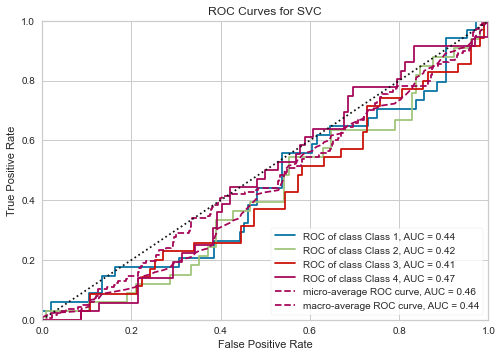

KNN
Melhores parâmetros - k:9, w:uniform, m:chebyshev
Accuracy: 0.271133
------------------------------------------------
AUC: 0.508606
-----------------------CURVA ROC---------------------


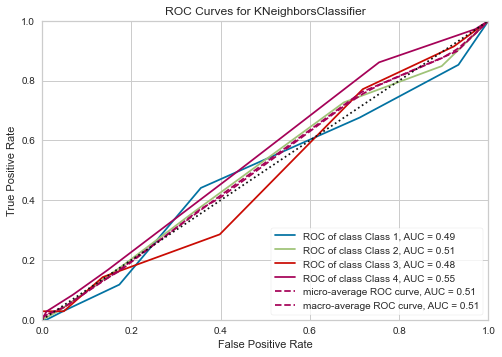

DT
Melhores parâmetros - md:8, c:gini
Accuracy: 0.268692
------------------------------------------------
AUC: 0.473788
-----------------------CURVA ROC---------------------


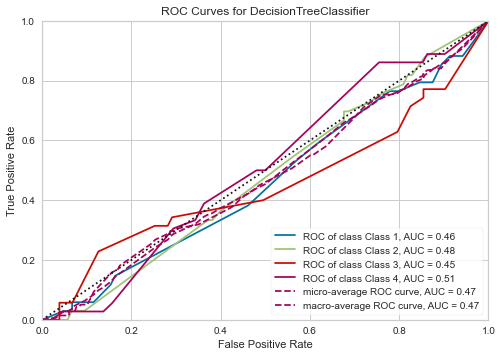

MLP
Melhores parâmetros - hls:(50, 15, 5), a:tanh, s:sgd, lr:adaptive, lri:0.0001
Accuracy: 0.272728
------------------------------------------------
AUC: 0.506264
-----------------------CURVA ROC---------------------


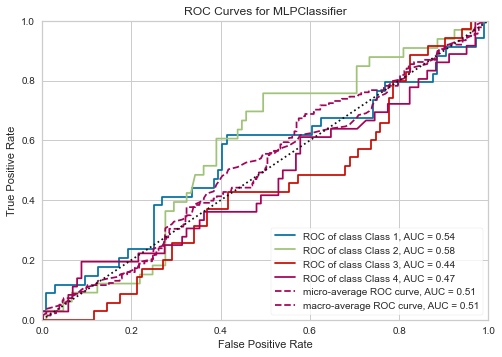

AUC: 0.480493
-----------------------CURVA ROC---------------------


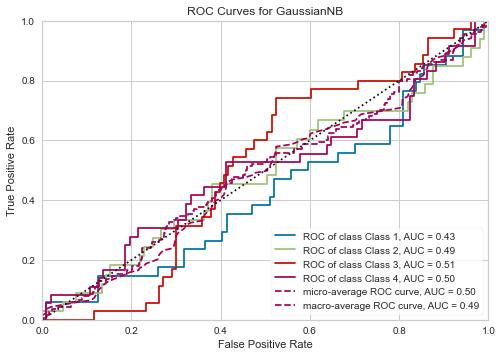

SVM
Melhores parâmetros - C:1, k:sigmoid
, g:1
Accuracy: 0.263058
------------------------------------------------
AUC: 0.527998
-----------------------CURVA ROC---------------------


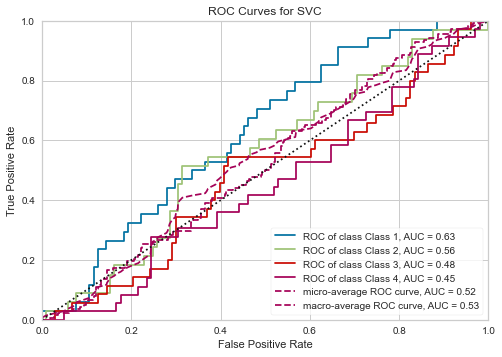

KNN
Melhores parâmetros - k:11, w:uniform, m:manhattan
Accuracy: 0.284795
------------------------------------------------
AUC: 0.448145
-----------------------CURVA ROC---------------------


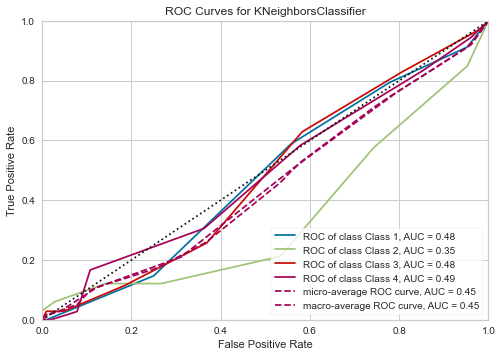

DT
Melhores parâmetros - md:6, c:gini
Accuracy: 0.273535
------------------------------------------------
AUC: 0.501590
-----------------------CURVA ROC---------------------


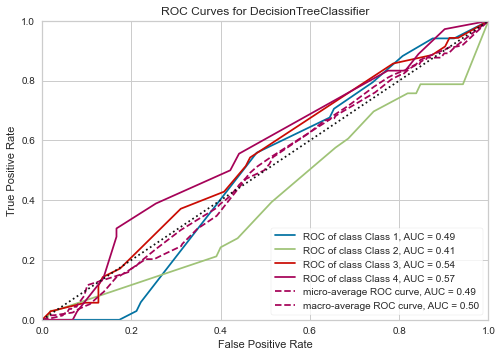

MLP
Melhores parâmetros - hls:(100,), a:tanh, s:adam, lr:constant, lri:0.0001
Accuracy: 0.281573
------------------------------------------------
AUC: 0.468360
-----------------------CURVA ROC---------------------


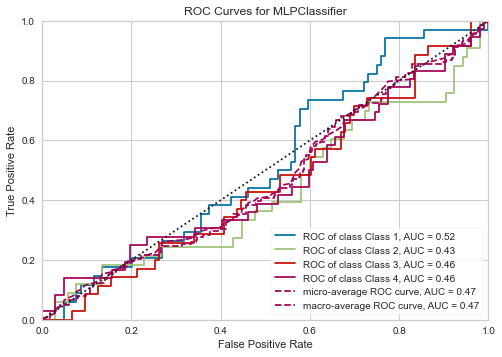

AUC: 0.518307
-----------------------CURVA ROC---------------------


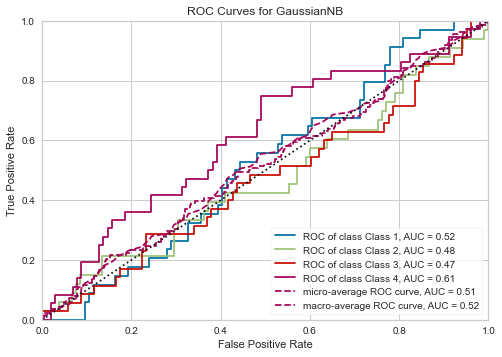

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.260660
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


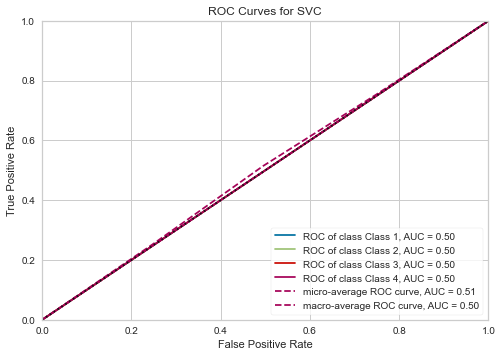

KNN
Melhores parâmetros - k:25, w:uniform, m:manhattan
Accuracy: 0.275155
------------------------------------------------
AUC: 0.504322
-----------------------CURVA ROC---------------------


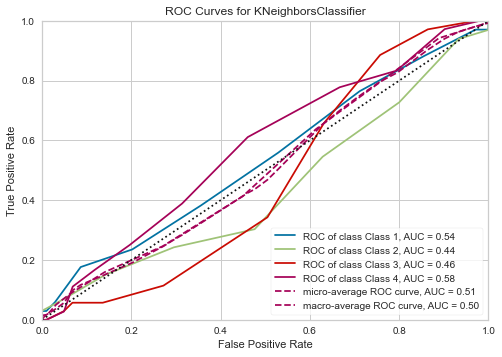

DT
Melhores parâmetros - md:12, c:gini
Accuracy: 0.276742
------------------------------------------------
AUC: 0.506554
-----------------------CURVA ROC---------------------


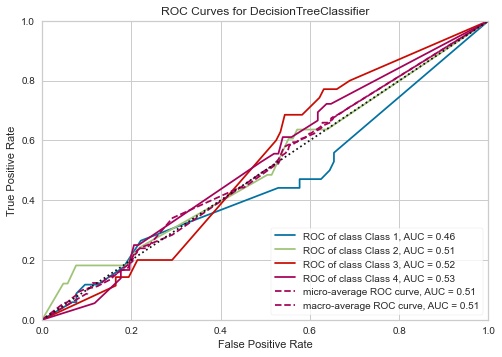

MLP
Melhores parâmetros - hls:(100, 25, 10), a:tanh, s:sgd, lr:adaptive, lri:0.05
Accuracy: 0.269511
------------------------------------------------
AUC: 0.489748
-----------------------CURVA ROC---------------------


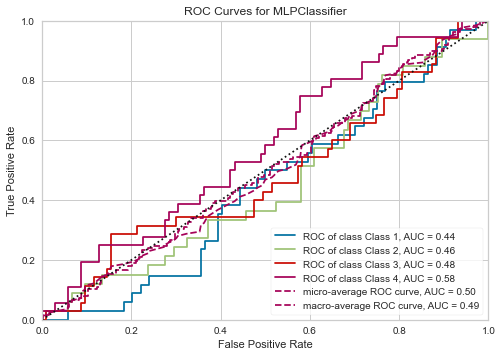

AUC: 0.508770
-----------------------CURVA ROC---------------------


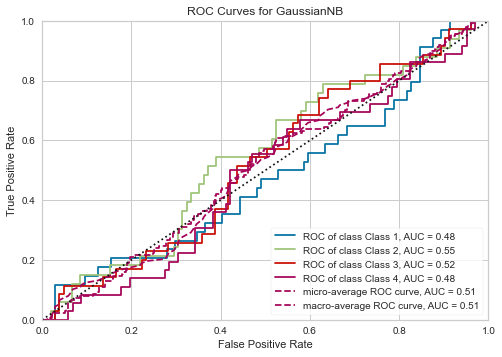

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.260660
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


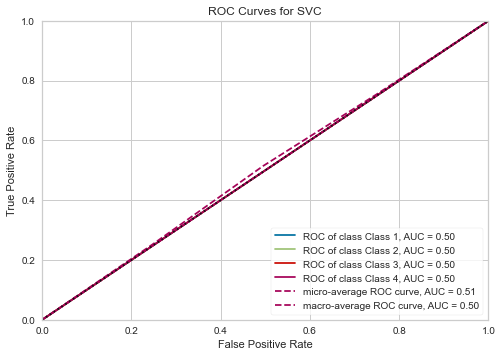

	GNB
Acurácia média (desvio): 0.256344 +- (0.024801)
F1-score média (desvio): 0.239831 +- (0.026545)
AUC média (desvio): 0.497672 +- (0.026264)

Matriz de Confusão:  
[[ 2.5  7.7 11.2 12.1]
 [ 3.9  7.9  9.6 11.7]
 [ 4.5  7.1 10.2 13.7]
 [ 3.2  7.2 10.8 14.8]]
	KNN
Acurácia média (desvio): 0.253436 +- (0.033486)
F1-score média (desvio): 0.252141 +- (0.033837)
AUC média (desvio): 0.496408 +- (0.027657)

Matriz de Confusão:  
[[ 9.8  8.7  9.1  5.9]
 [ 8.   7.1 10.2  7.8]
 [11.3  8.4  8.6  7.2]
 [ 9.1  8.2  9.2  9.5]]
	DT
Acurácia média (desvio): 0.239714 +- (0.031528)
F1-score média (desvio): 0.206386 +- (0.035928)
AUC média (desvio): 0.500803 +- (0.018585)

Matriz de Confusão:  
[[ 2.9 12.1 10.8  7.7]
 [ 3.3 10.7 10.4  8.7]
 [ 4.5 11.5 11.7  7.8]
 [ 3.8 11.1 13.3  7.8]]
	MLP
Acurácia média (desvio): 0.251960 +- (0.029347)
F1-score média (desvio): 0.248723 +- (0.029714)
AUC média (desvio): 0.493846 +- (0.014417)

Matriz de Confusão:  
[[ 7.8  8.4  7.9  9.4]
 [ 7.4  7.6  8.5  9.6]
 [ 8.   

In [14]:
#%%time
#ignorando warnings
warnings.filterwarnings('ignore')

evaluate_model_with_kfold(StratifiedKFold(n_splits=10, shuffle=True, random_state=199))

## Plotando Matrizes de Confusão

In [15]:
def mc_plot(df,model):
    df.rename(columns={0:1, 1:2, 2:3, 3:4}, index={0:1, 1:2, 2:3, 3:4}, inplace=True)
    #fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(
        df, 
        cmap="Blues", 
        annot=True, 
        fmt="0.1f",
        annot_kws={
            'fontsize': 11,
            'fontweight': 'bold'
        },
        linewidth=0.8,
        linecolor='gray',
        square=True
   ).set_title(model)

In [16]:
knn_conf_mtx = np.array([[ 9.8,  8.7,  9.1,  5.9],
 [ 8.,   7.1, 10.2,  7.8],
 [11.3,  8.4,  8.6,  7.2],
 [ 9.1,  8.2,  9.2,  9.5]])

dt_conf_mtx = np.array([[ 2.9, 12.1, 10.8,  7.7],
 [ 3.3, 10.7, 10.4,  8.7],
 [ 4.5, 11.5, 11.7,  7.8],
 [ 3.8, 11.1, 13.3,  7.8]])

gnb_conf_mtx = np.array([[ 2.5,  7.7, 11.2, 12.1],
 [ 3.9,  7.9,  9.6, 11.7],
 [ 4.5,  7.1, 10.2, 13.7],
 [ 3.2,  7.2, 10.8, 14.8]])

mlp_conf_mtx = np.array([[ 7.8,  8.4,  7.9,  9.4],
 [ 7.4,  7.6,  8.5,  9.6],
 [ 8.,   7.6,  8.8, 11.1],
 [ 9.4,  7.6,  8.4, 10.6]])

svm_conf_mtx = np.array([[ 3.4,  3.8,  1.8, 24.5],
 [ 2.9,  4.1,  4.4, 21.7],
 [ 4.8,  5.,   2.4, 23.3],
 [ 3.7,  3.4,  3.4, 25.5]])

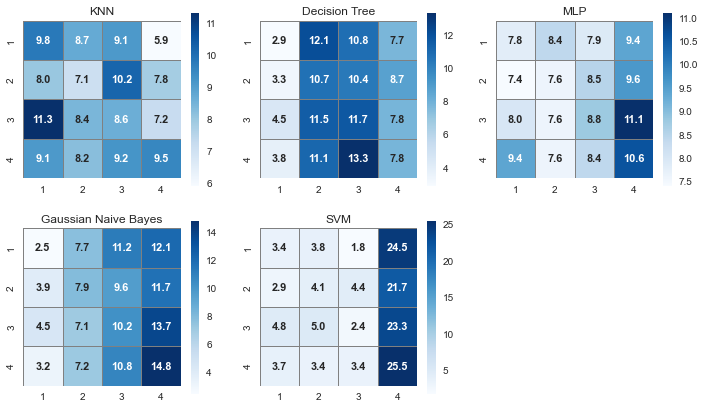

In [17]:
plt.figure(figsize=(12,7))
plt.subplot(2,3,1)
mc_plot(pd.DataFrame(knn_conf_mtx),'KNN')

plt.subplot(2,3,2)
mc_plot(pd.DataFrame(dt_conf_mtx),'Decision Tree')

plt.subplot(2,3,3)
mc_plot(pd.DataFrame(mlp_conf_mtx),'MLP')

plt.subplot(2,3,4)
mc_plot(pd.DataFrame(gnb_conf_mtx),'Gaussian Naive Bayes')

plt.subplot(2,3,5)
mc_plot(pd.DataFrame(svm_conf_mtx),'SVM')